# Churn Prediction

In this notebook, we build predictive models for customer churn.  
We compare five approaches for churn prediction:  

1. **Logistic Regression (Linear):** baseline model assuming a linear relationship between features and churn.  
2. **Logistic Regression (Polynomial):** extended with quadratic and interaction terms, regularized to prevent overfitting.  
3. **Random Forest Classifier:** an ensemble of decision trees using bagging to capture non-linear patterns.  
4. **Gradient Boosting Classifier:** sequentially built decision trees where each corrects the errors of the previous ones.  
5. **Feedforward Neural Network (FFNN / MLP):** a deep learning model with multiple hidden layers, batch normalization, and dropout, implemented in PyTorch.  

Our goal is to evaluate how well each model predicts churn and compare their performance. All models are evaluated using classification metrics and ROC-AUC to provide a fair comparison of their predictive performance.


In [1]:
# Imports
from src.db_utils import load_features
from src.data_prep import preprocess, preprocess_sklearn
from src.models import FeedforwardNN
from src.train import train_model
from src.evaluate import evaluate_pytorch

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


## 1. Load Data from SQL and Preprocess 

We first load the engineered features from SQL.  


In [2]:
# Load dataset from SQL
df = load_features("sql/feature_engineering.sql")

# Preprocess for Logistic Regression
X_train, X_test, y_train, y_test = preprocess_sklearn(df)

# Preprocess for Neural Network (PyTorch)
train_loader, test_loader, input_dim = preprocess(df)


/Users/tanjintoma/Desktop/Prepare_data_science/SQL/churn_IBM_dataset/telco-churn-prediction/src/db_utils.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## 2a. Linear Logistic Regression

We train a Logistic Regression model as a baseline for churn prediction.  
This model assumes a linear relationship between features and churn.


Classification Report (Linear Logistic Regression):
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1035
           1       0.64      0.58      0.61       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409

ROC-AUC: 0.8467229843188923


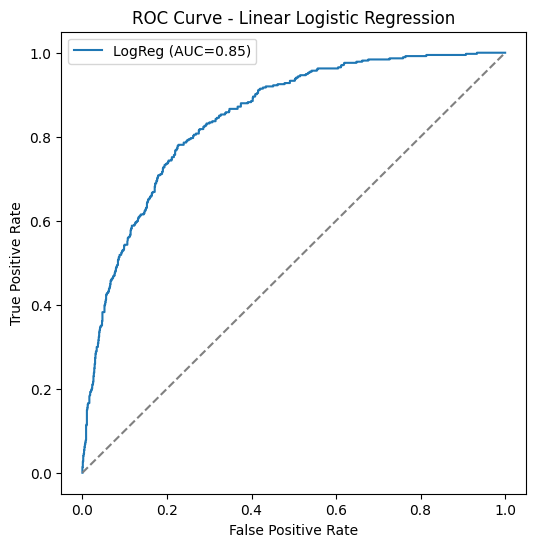

In [3]:
from sklearn.linear_model import LogisticRegression

#Linear logistic regression 
logreg_linear = LogisticRegression(max_iter=500)
logreg_linear.fit(X_train, y_train)

y_pred_lin = logreg_linear.predict(X_test)
y_proba_lin = logreg_linear.predict_proba(X_test)[:, 1]

print("Classification Report (Linear Logistic Regression):")
print(classification_report(y_test, y_pred_lin))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lin))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_lin)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc_auc_score(y_test, y_proba_lin):.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear Logistic Regression")
plt.legend()
plt.show()


## 2b. Polynomial Logistic Regression

We extend Logistic Regression by including polynomial (quadratic) and interaction terms between features.  
This allows the model to capture non-linear relationships in the data.  
Because polynomial expansion increases the number of features, we apply L2 regularization to reduce the risk of overfitting.

Classification Report (Polynomial Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.59      0.55      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC: 0.8338784262057919


/opt/anaconda3/envs/telco_churn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


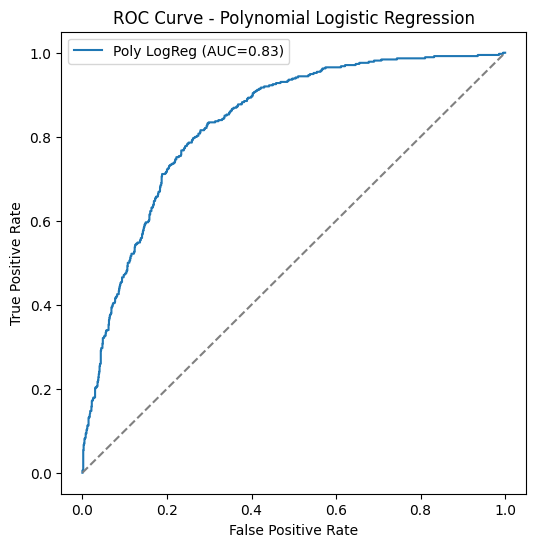

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Pipeline: Polynomial Features + Logistic Regression
poly_logreg = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # quadratic features
    ("logreg", LogisticRegression(
        max_iter=500,
        penalty="l2",        # "l2" (Ridge), "l1" (Lasso), or "elasticnet"
        C=100,               # inverse of regularization strength (smaller = stronger reg.)
        solver="saga"        # supports L1/elasticnet
    ))
])

# Train
poly_logreg.fit(X_train, y_train)

# Predictions
y_pred = poly_logreg.predict(X_test)
y_proba = poly_logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (Polynomial Logistic Regression):")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Poly LogReg (AUC={roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Polynomial Logistic Regression")
plt.legend()
plt.show()


## 3. Random Forest Classifier

Random Forest is an ensemble learning method that builds multiple decision trees and aggregates their predictions.  
It helps reduce overfitting compared to a single decision tree and captures non-linear relationships between features.  
In this implementation, we use 200 trees with balanced class weights to handle churn class imbalance.  

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409

ROC-AUC: 0.829256761993335


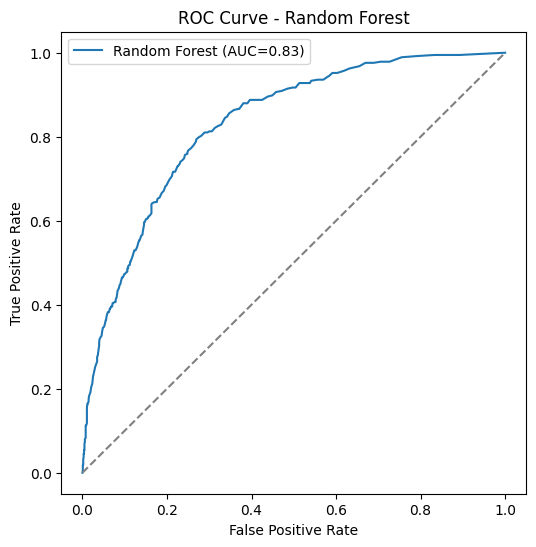

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,   # number of trees
    max_depth=None,     # let trees grow fully (or set like 5, 10)
    random_state=42,
    class_weight="balanced"   # helpful if churn is imbalanced
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc_score(y_test, y_proba_rf):.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()



## 4. Gradient Boosting Classifier

Gradient Boosting is an ensemble technique that builds decision trees sequentially, where each new tree corrects the errors of the previous ones.  
Unlike Random Forest, which averages multiple independent trees, Gradient Boosting focuses on minimizing errors stage by stage, often leading to higher predictive accuracy.  In this setup, we train 200 boosting stages with a learning rate of 0.05 and maximum tree depth of 3.  

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

ROC-AUC: 0.8406081273088946


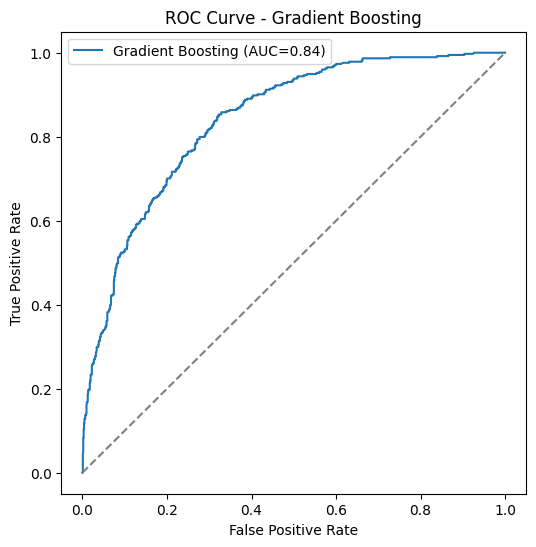

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=200,   # number of boosting stages
    learning_rate=0.05, # smaller = slower but better generalization
    max_depth=3,        # depth of each tree
    random_state=42
)
gb.fit(X_train, y_train)

# Predictions
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_gb))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_gb)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Gradient Boosting (AUC={roc_auc_score(y_test, y_proba_gb):.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()


## 5. Feedforward Neural Network (FFNN / MLP)

We now train a Feedforward Neural Network (FFNN), also known as a Multilayer Perceptron (MLP), to capture complex non-linear relationships in the data.  
This model has three hidden layers with ReLU activations.  
To improve generalization and reduce overfitting, Batch Normalization is applied after each layer and Dropout is used with progressively smaller rates (50%, 40%, 30%).  The final output layer produces a single logit, which is passed through a sigmoid function during evaluation to estimate the churn probability.


Epoch 1/50, Train Loss: 0.5402, Val Loss: 0.4801
Epoch 2/50, Train Loss: 0.4811, Val Loss: 0.4330
Epoch 3/50, Train Loss: 0.4590, Val Loss: 0.4314
Epoch 4/50, Train Loss: 0.4502, Val Loss: 0.4358
Epoch 5/50, Train Loss: 0.4574, Val Loss: 0.4300
Epoch 6/50, Train Loss: 0.4468, Val Loss: 0.4173
Epoch 7/50, Train Loss: 0.4413, Val Loss: 0.4283
Epoch 8/50, Train Loss: 0.4325, Val Loss: 0.4201
Epoch 9/50, Train Loss: 0.4400, Val Loss: 0.4127
Epoch 10/50, Train Loss: 0.4372, Val Loss: 0.4167
Epoch 11/50, Train Loss: 0.4308, Val Loss: 0.4170
Epoch 12/50, Train Loss: 0.4339, Val Loss: 0.4178
Epoch 13/50, Train Loss: 0.4331, Val Loss: 0.4136
Epoch 14/50, Train Loss: 0.4338, Val Loss: 0.4130
Epoch 15/50, Train Loss: 0.4266, Val Loss: 0.4095
Epoch 16/50, Train Loss: 0.4328, Val Loss: 0.4151
Epoch 17/50, Train Loss: 0.4318, Val Loss: 0.4127
Epoch 18/50, Train Loss: 0.4316, Val Loss: 0.4145
Epoch 19/50, Train Loss: 0.4267, Val Loss: 0.4123
Epoch 20/50, Train Loss: 0.4289, Val Loss: 0.4117
Epoch 21/

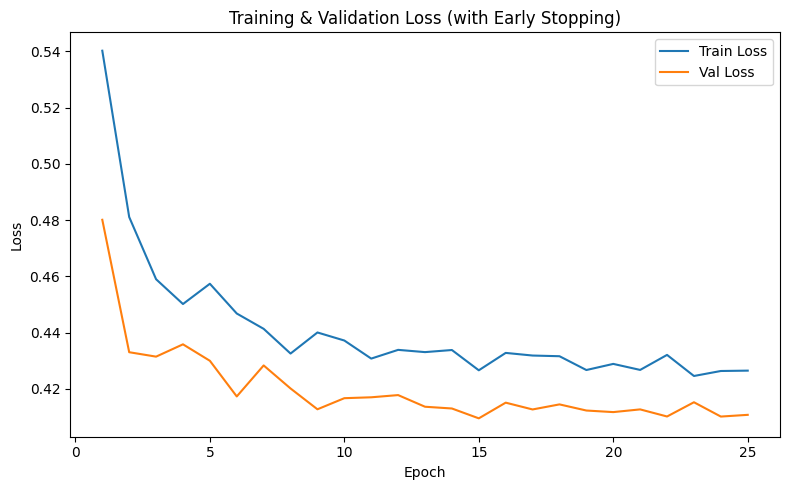

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      1035
         1.0       0.63      0.58      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.8465473145780051


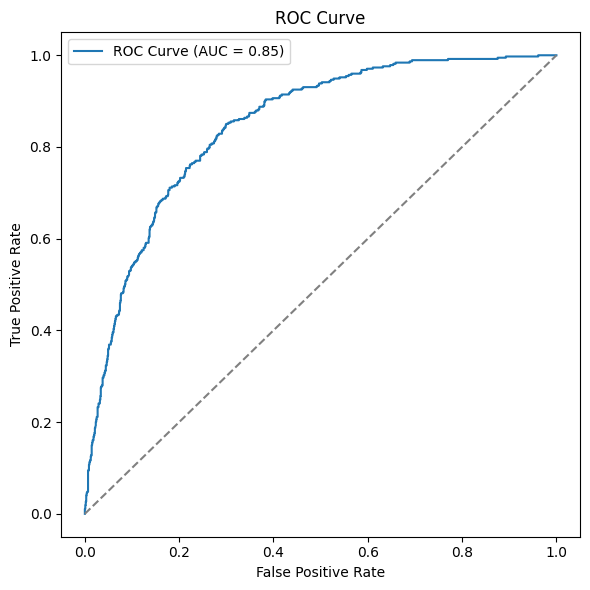

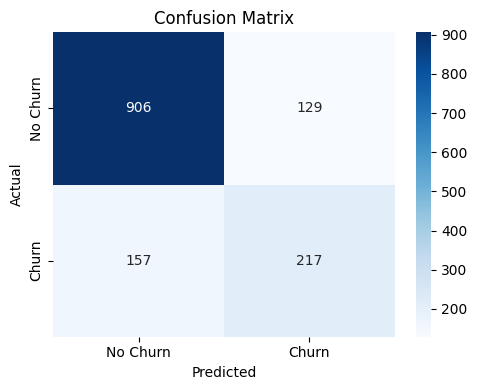

In [7]:
# Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FeedforwardNN(input_dim)

# Train (loss curve will be plotted automatically)
model = train_model(model, train_loader, test_loader, epochs=50, lr=0.0005, device=device, patience=10)

# Evaluate (classification report + ROC curve)
evaluate_pytorch(model, test_loader, device=device)



## 6. Model Comparison and Insights

- **Linear Logistic Regression** performed strongly as a baseline, achieving ~0.85 ROC-AUC and 80% accuracy.  
- **Polynomial Logistic Regression** did not improve performance (ROC-AUC ~0.83) and showed signs of overfitting despite regularization.  
- **Random Forest** achieved a similar ROC-AUC (~0.83) but had lower recall for churned customers, suggesting bias toward the majority class.  
- **Gradient Boosting** slightly improved over Random Forest (ROC-AUC ~0.84) and provided a better balance of precision and recall, confirming its strength for tabular data.  
- **Feedforward Neural Network (FFNN / MLP)** matched the best performance (~0.85 ROC-AUC) but did not significantly surpass simpler models, likely because the Telco dataset is relatively small and low-dimensional. Deep learning models typically show clearer benefits with larger, more complex datasets.  


